## Content

* ### [Introduction](#introduction)
    * #### [Data Management](#data-mgmt)
* ### [Feature Engineering](#feature-eng)
    * ### [Normalizing data](#normalizing)
* ### [Feature Selection](#feature-sel)
* ### Modelling
* ### Model Evaluation

# Introduction <a name="introduction"></a>

Predicting the stock market has always been an attractive topic, mainly because of its vitality in the economic and ﬁnancial sectors. Yet, predictions of the stockmarket pose a challenging exercise, even to the brightest and sharpest minds in the business. Prediction of stock market is never an easy task, due to the complexity and dynamic characteristics of the data it deals with. 

There are several unique challenges present in this domain that are not present in other common areas of machine learning such as Natural Language Processing, spam detection, computer vision and others. These challenges include:
* Swithing of regimes (non-stationarity)
* Reflexivity (market adaptation)
* Low signal-to-noise ratio

In this project, I tried to predict the next day's change in price of an asset using only historical data and technical indicators.


Import all libraries

In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import technical_indicator as ti
import plotting as pl

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler,Normalizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import datetime as dt


## Data Management <a name="data-mgmt"></a>

**`features`**

Contains all features to be used for prediction. To avoid look-ahead bias, the dataframe only contains values that would have been known at that point in time. I'll explain about look-ahead bias later.

**`outcomes`**

Contains all possible outcomes to be predicted, conviniently shifted back in time. For example, if we wanted to predict the next day return, we would look ahead one day into the future, calculate the metric and record it at time T=0.

This makes it very easy to extract X and y for fitting models and join both dataframes as the rows are already aligned. 

Let's start from downloading the dataset. I used yfinance package to download prices.

Note: Set auto_adjust parameter to True so that the prices are adjusted for splits and dividends. 


In [37]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'SPY']
df = yf.download(tickers, period='10y', auto_adjust=True, group_by='ticker')
df.head(200)

[*********************100%***********************]  4 of 4 completed


AMZN                                               \
                  Open        High         Low       Close   Volume   
Date                                                                  
2011-03-31  179.309998  181.570007  178.500000  180.130005  4826500   
2011-04-01  181.580002  183.250000  178.589996  180.130005  5684100   
2011-04-04  180.889999  183.610001  180.690002  182.940002  4186400   
2011-04-05  182.100006  186.360001  181.800003  185.289993  5569200   
2011-04-06  186.149994  188.270004  181.119995  182.759995  5430700   
...                ...         ...         ...         ...      ...   
2012-01-09  182.759995  184.369995  177.000000  178.559998  5056900   
2012-01-10  181.100006  182.399994  177.100006  179.339996  3985800   
2012-01-11  179.639999  180.770004  178.190002  178.899994  3102700   
2012-01-12  179.419998  179.490005  175.750000  175.929993  5385800   
2012-01-13  175.809998  178.800003  173.500000  178.419998  4753500   

                 MSFT                                                    SPY  \
                 Open       High        Low      Close    Volume        Open   
Date                                                                           
2011-03-31  20.427046  20.490880  20.219584  20.259480  63233700  108.783366   
2011-04-01  20.371196  20.371196  20.195650  20.331299  63114200  109.447882   
2011-04-04  20.307352  20.474917  20.275434  20.387144  35433700  109.464271   
2011-04-05  20.602593  20.889849  20.538759  20.570677  73651100  109.111513   
2011-04-06  20.730259  20.993577  20.634508  20.865908  65581400  109.833456   
...               ...        ...        ...        ...       ...         ...   
2012-01-09  22.841583  22.882300  22.572859  22.589146  59706800  106.748919   
2012-01-10  22.743872  22.923022  22.597295  22.670584  60014400  107.908144   
2012-01-11  22.336710  22.784583  22.287851  22.572861  65582400  107.357710   
2012-01-12  22.695014  22.817161  22.515863  22.800875  49370800  108.058251   
2012-01-13  22.743871  23.004452  22.629867  23.004452  60196100  107.282647   

                                                                AAPL  \
                  High         Low       Close     Volume       Open   
Date                                                                   
2011-03-31  109.078706  108.660300  108.775154  132537100  10.655063   
2011-04-01  109.743222  108.972056  109.234573  153850100  10.801189   
2011-04-04  109.661168  109.013068  109.324806  100768900  10.592002   
2011-04-05  109.792436  109.062292  109.308411  120791500  10.366819   
2011-04-06  109.931898  109.209953  109.652969  120411600  10.496944   
...                ...         ...         ...        ...        ...   
2012-01-09  106.899029  106.256876  106.765602   99530200  13.089651   
2012-01-10  108.124973  107.541192  107.691315  115282000  13.102258   
2012-01-11  107.891454  107.182582  107.749680  111540700  13.002897   
2012-01-12  108.166659  107.199244  108.008202  118983700  12.990590   
2012-01-13  107.624581  106.515391  107.449440  179836200  12.911224   

                                                        
                 High        Low      Close     Volume  
Date                                                    
2011-03-31  10.760888  10.645835  10.721204  274019200  
2011-04-01  10.815955  10.560929  10.599690  418661600  
2011-04-04  10.600923  10.410193  10.496021  460084800  
2011-04-05  10.528632  10.336363  10.425268  482731200  
2011-04-06  10.579389  10.371431  10.399117  402539200  
...               ...        ...        ...        ...  
2012-01-09  13.158867  12.961984  12.973674  394024400  
2012-01-10  13.105027  12.966593  13.020121  258196400  
2012-01-11  13.008128  12.899227  12.998899  215084800  
2012-01-12  13.009663  12.881997  12.963211  212587200  
2012-01-13  12.934296  12.879230  12.914607  226021600  

[200 rows x 20 columns]

Visualising the datasets. I applied log function because Amazon stock were significantly higher, so it is impossible to visualise the prices of all three stocks

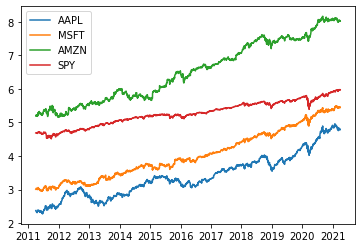

In [3]:
for ticker in tickers:
    plt.plot(df[ticker]['Close'].apply(np.log), label=ticker)
    
plt.legend()
    

# Feature Engineering <a name="feature-eng"></a>

Feature Engineering refers to pre-processing of raw data into a format which is more easily understood by machine learning algorithms. 

I believe it is one of the most important and underappreciated activities in machine learning. 


**Important considerations**

Since we are dealing with time-series data, it is crucial to be aware of potential challenges and biases we may introduce, whether intentially or unintentially.

**`Look-ahead bias`**

Look-ahead bias occurs when the information or data that is not available in the analysis period is used for a simulation. This can lead to innacurate results which are often overoptimistic. 

**`False ordinality`**

We should also avoid representing features in ordinal way if it has no meaning. For example, it is not the best approach to represent day of a week as an integer from 1 to 7 because we will be telling the model to treat one day differently than the other.



### Features to be considered:
`1`. Moving Averages

Moving average is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. Variations include: simple, and cumulative, or weighted forms. 
We'll be using simple and exponential moving averages as features and also to construct other features.

`2`. Daily return

Percent change between closing price and opening price

`3`. Log volume

Volume transformed to log scale.

`4`. Price difference

Difference between today's and yesterday's closing price

`5`. Relative Strength Index

Measures the magnitude of recent price changes. Commonly used in technical analysis to evaluate overbought or oversold conditions in the price of a stock.
This indicator was developed by J.Welles Wilder Jr.
According to this indicator, a stock is considered overbought when the RSI is above 70% and oversold when it is below 30%.

`6`. Stochastic Oscillator

The Stochastic Oscillator is a momentum indicator that compares a specific closing price of a security to its high-low range over a certain period of time. First developed in the 1950s, it is a popular momentum indicator to identify overbought and oversold conditions of an asset. 

`7`. Moving Average Convergence Divergence (MACD)
MACD is a trend-following momentum indicator that demonstrates the relationship between two moving averages - long-term and short-term. MACD is calculated as 

MACD = EMA(26-period) - EMA(12-period)

MACD is often used together with Relative Strength (RSI) to show a more complete picture of a market.

The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.


`8`. Average True Range(ATR)

ATR is a market volatility indicator. Introduced by market technician J.Welles Wilder Jr., this indicator measures market volatility by decomposing the complete range of a security price for that period.


`9`. Accumulation/Distribution Indicator (A/D)

The accumulation/distribution indicator (A/D) is a cumulative indicator that makes us of price and volume to assess whether an asset is being accumulated or distributed.

`10`. Money Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.



### Target variable

We will be prediciting the next day's change in price.


In [4]:
feature_names = ['daily_return', 'price_diff', 'vol_log']
col_names = pd.MultiIndex.from_product([tickers, feature_names])
features = pd.DataFrame(index=df.index, columns=col_names).sort_index()

for ticker in tickers:
    features.loc[:, (ticker, 'daily_return')] = df[ticker]['Close'] / df[ticker]['Open'] - 1
    features.loc[:, (ticker, 'price_diff')] = df[ticker]['Close'].diff(1)
    features.loc[:, (ticker, 'vol_log')] = df[ticker]['Volume'].apply(np.log)
    features.loc[:, (ticker, 'vol_diff_1')] = df[ticker]['Volume'].diff(1)
    features.loc[:, (ticker, 'vol_diff_50')] = df[ticker]['Volume'].diff(50)
    
    # Rate of change in volume
    features.loc[:, (ticker, 'roc_vol')] = ti.rate_of_change(df[ticker]['Volume'])
    
    for period in [5, 10, 20, 50, 100, 200]:
        
        # Moving average of volume (log)
        features.loc[:, (ticker, 'sma{}_vol'.format(period))] = ti.simple_ma(features[ticker]['vol_log'], period=period)
        
        # Closing price vs n-day EMA 
        features.loc[:, (ticker, 'close_vs_ema{}'.format(period))] = df[ticker]['Close'] / ti.exp_ma(df[ticker]['Close'], period=period) - 1
         
        # Daily Volume vs. n-day SMA
        features.loc[:, (ticker, 'vol_vs_sma{}'.format(period))] = df[ticker]['Volume'] / ti.simple_ma(df[ticker]['Volume'], period=period) - 1
    
    # Average True Range (14-day)
    features.loc[:, (ticker, 'atr')] = ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])
    
    # High divided by Average True Range with window of 10
    features.loc[:, (ticker, 'high10atr')] = df[ticker]['High'] / ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'], period=10)
       
    # Relative Strengh Index (RSI)
    features.loc[:, (ticker, 'RSI')] = ti.RSI(df[ticker]['Close'])
    
    # Money Flow Index (MFI)
    features.loc[:, (ticker, 'MFI')] = ti.money_flow_index(df[ticker]['Volume'], df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])

    # Stochastic Oscillator
    features.loc[:, (ticker, 'STOCH')] = ti.stochastic_oscillator(df[ticker]['Close'], df[ticker]['High'], df[ticker]['Low'])
    
    # Moving Average Convergence Divergence (MACD)
    features.loc[:, (ticker, 'MACD')] = ti.MACD(df[ticker]['Close']).iloc[:, 0]
    features.loc[:, (ticker, 'MACD_signal')] = ti.MACD(df[ticker]['Close']).iloc[:, 1]

    # Accumulation/Distribution
    features.loc[:, (ticker, 'ADI')] = ti.accumulation_distribution(df[ticker]['Close'], df[ticker]['Low'], df[ticker]['High'], df[ticker]['Volume'])

outcome_names = ['target_close_1']
col_names_out = pd.MultiIndex.from_product([tickers, outcome_names])
outcomes = pd.DataFrame(index=df.index, columns=col_names_out).sort_index()

for ticker in tickers:
    # Change in closing price in the next day
    outcomes.loc[:, (ticker, 'target_close_1')] = df[ticker]['Close'].pct_change(-1)

In [5]:
df_new = features.join(outcomes)
df_new = df_new.dropna()

# Feature Selection <a name="feature-sel"></a>

In feature selection process, we aim to meet two objectives:

*Strength*: Choose the features with the strongest, most persistent relationships to the target outcome variable. The reasons for this are obvious.

*Reduce collinearity between features*: Minimize the amount of or collinearity in our selected features. 

### Normalizing data <a name="normalizing"></a>

Before diving into evaluation of the features for predictive strength, we will standardize data given that we have data of different scales.

For that, we can use StandardScaler() method as part of scikit-learn package.

In [6]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, index=df.index)
df_scaled.columns = df.columns


### Correlation with target variable

For simplicity purposes, going forward we will only consider the price of ETF S&P 500

<AxesSubplot:title={'center':'Strength of Correlation'}>

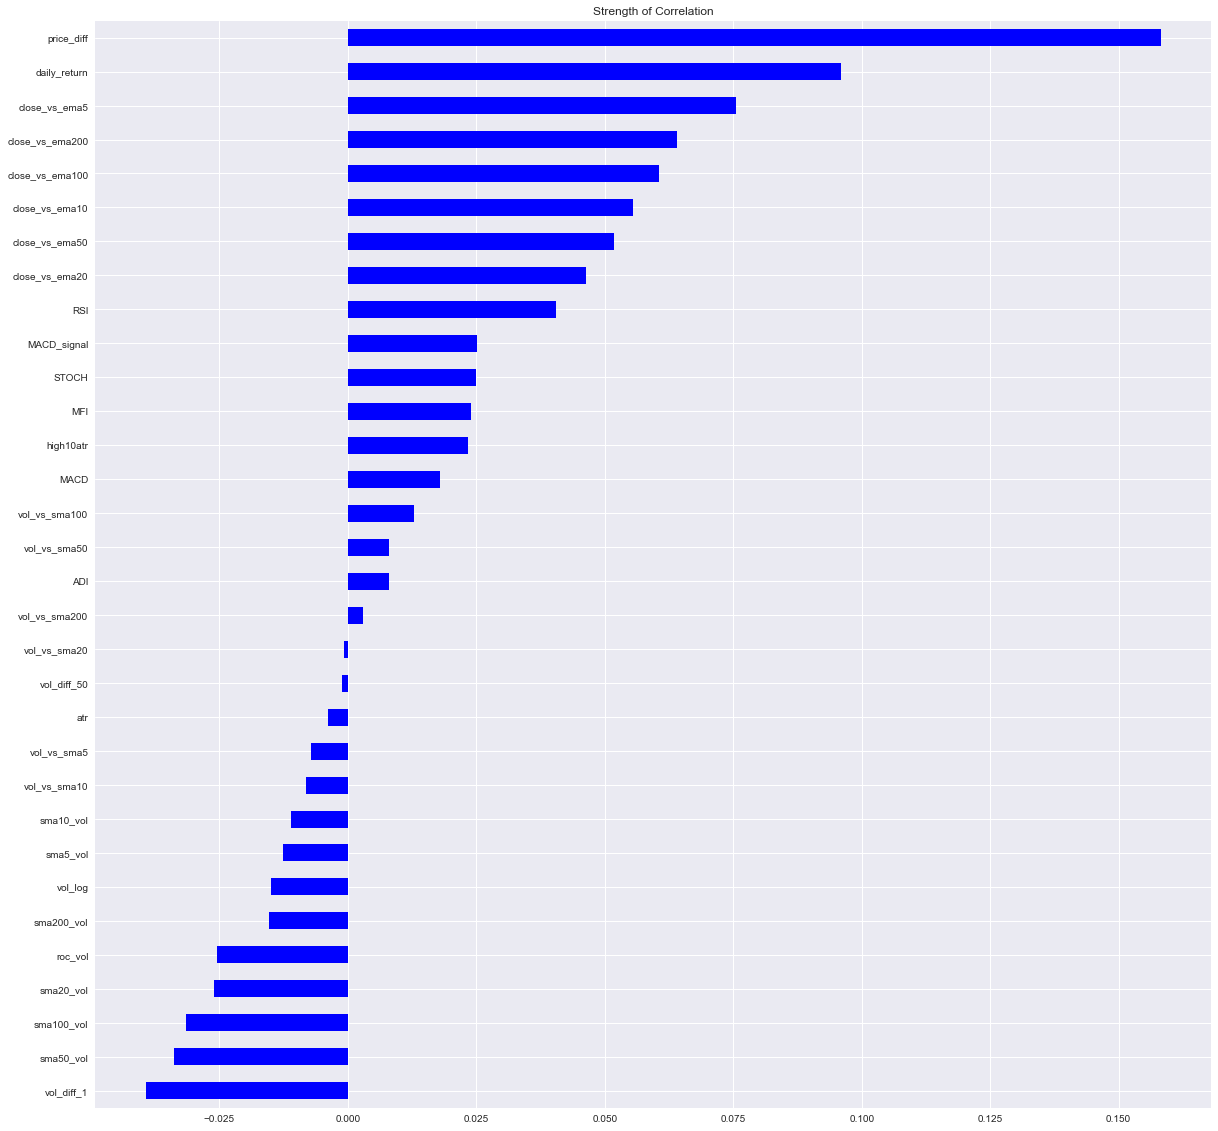

In [7]:
# Correlation strength
plt.style.use('seaborn')
plt.figure(figsize=(20,20))

corr = features['SPY'].corrwith(df_new['SPY']['target_close_1'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')


For simplicity purposes, going forward we will only consider the price of ETF S&P 500

Even though correlation is not the ideal metric, it should give us an idea of strengh of each feature's relationship to the target variable.

However, it gives us no information about multicollinearity. 

We can leverage seaborn's clustermap chart that plots a heatmap representation of a covariance matrix.

It is important to note that scaling the features before runtime is a form of data leakage (I mentioned look-ahead bias earlier). However, for the purpose of EDA and to understand better the feature set, it can be justified.
Of course, we will not be using these scaled features when it comes to model training and testing as this would not have been available at that time.



In [8]:
feats_max_corr = corr[corr > 0.02].index
corr.sort_values(ascending=False)

price_diff         0.158175
daily_return       0.095937
close_vs_ema5      0.075617
close_vs_ema200    0.064000
close_vs_ema100    0.060476
close_vs_ema10     0.055436
close_vs_ema50     0.051873
close_vs_ema20     0.046265
RSI                0.040569
MACD_signal        0.025081
STOCH              0.024901
MFI                0.023878
high10atr          0.023339
MACD               0.017950
vol_vs_sma100      0.012857
vol_vs_sma50       0.008055
ADI                0.007905
vol_vs_sma200      0.002897
vol_vs_sma20      -0.000831
vol_diff_50       -0.001145
atr               -0.003780
vol_vs_sma5       -0.007247
vol_vs_sma10      -0.008181
sma10_vol         -0.011148
sma5_vol          -0.012673
vol_log           -0.014918
sma200_vol        -0.015444
roc_vol           -0.025554
sma20_vol         -0.026075
sma100_vol        -0.031514
sma50_vol         -0.033769
vol_diff_1        -0.039256
dtype: float64

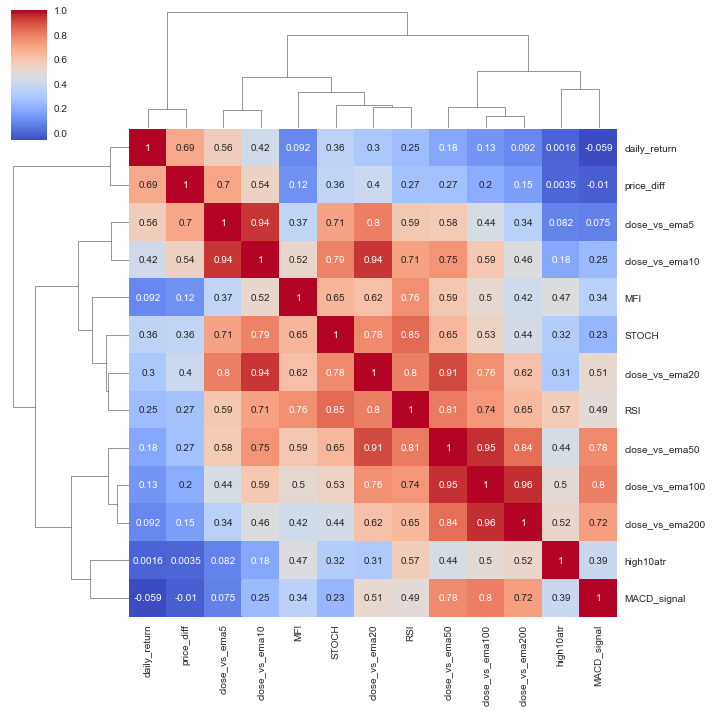

In [9]:
sns.clustermap(features['SPY'][feats_max_corr].corr(), cmap='coolwarm', annot=True, method='ward')

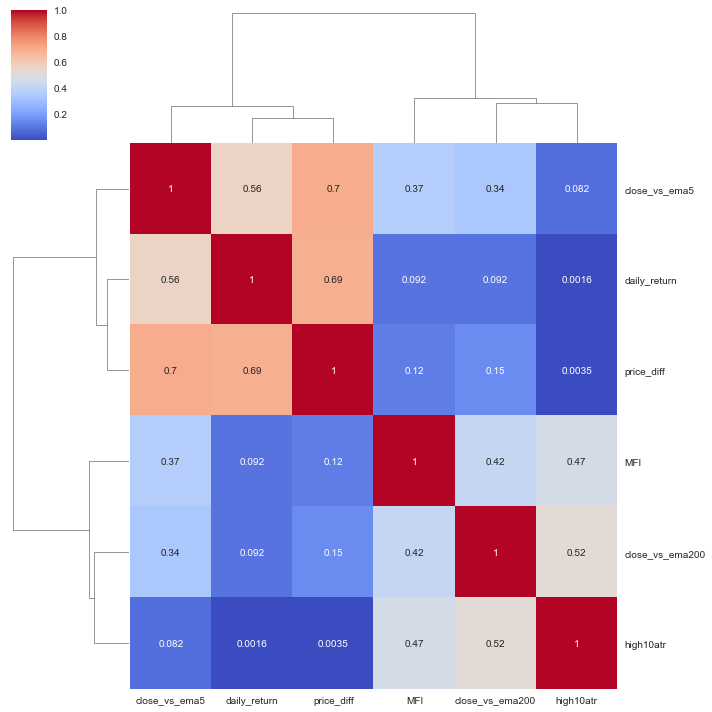

In [10]:
feats_selected = feats_max_corr.drop(['close_vs_ema10', 'close_vs_ema100', 
                                      'close_vs_ema20', 'RSI', 'close_vs_ema50', 
                                      'MACD_signal', 'STOCH'])
sns.clustermap(features['SPY'][feats_selected].corr(), cmap='coolwarm', annot=True, method='ward')


In [11]:
features_selected = df_new['SPY'][feats_selected]
df_SPY = df_new['SPY'].loc[:, features_selected.columns]

df_SPY = df_SPY.join(df_new['SPY']['target_close_1'])
df_SPY

,daily_return,price_diff,close_vs_ema5,close_vs_ema200,high10atr,MFI,target_close_1
Date,,,,,,,
2012-01-13,0.001555,-0.558762,0.000185,0.043232,93.923072,69.834158,-0.003866
2012-01-17,-0.005689,0.416977,0.002707,0.046712,90.563113,70.546197,-0.010935
2012-01-18,0.011291,1.192604,0.009153,0.057577,98.598702,71.803731,-0.005249
2012-01-19,0.001829,0.575462,0.009606,0.062389,101.441996,78.085839,-0.003713
2012-01-20,0.005410,0.408638,0.008873,0.065540,108.155932,78.321270,0.002583
...,...,...,...,...,...,...,...
2021-03-23,-0.006149,-3.089996,-0.003935,0.102505,85.992079,55.001468,0.005109
2021-03-24,-0.008900,-1.980011,-0.006017,0.095844,83.886563,58.167518,-0.005594
2021-03-25,0.009638,2.180023,-0.000283,0.100892,82.361506,48.545914,-0.015859


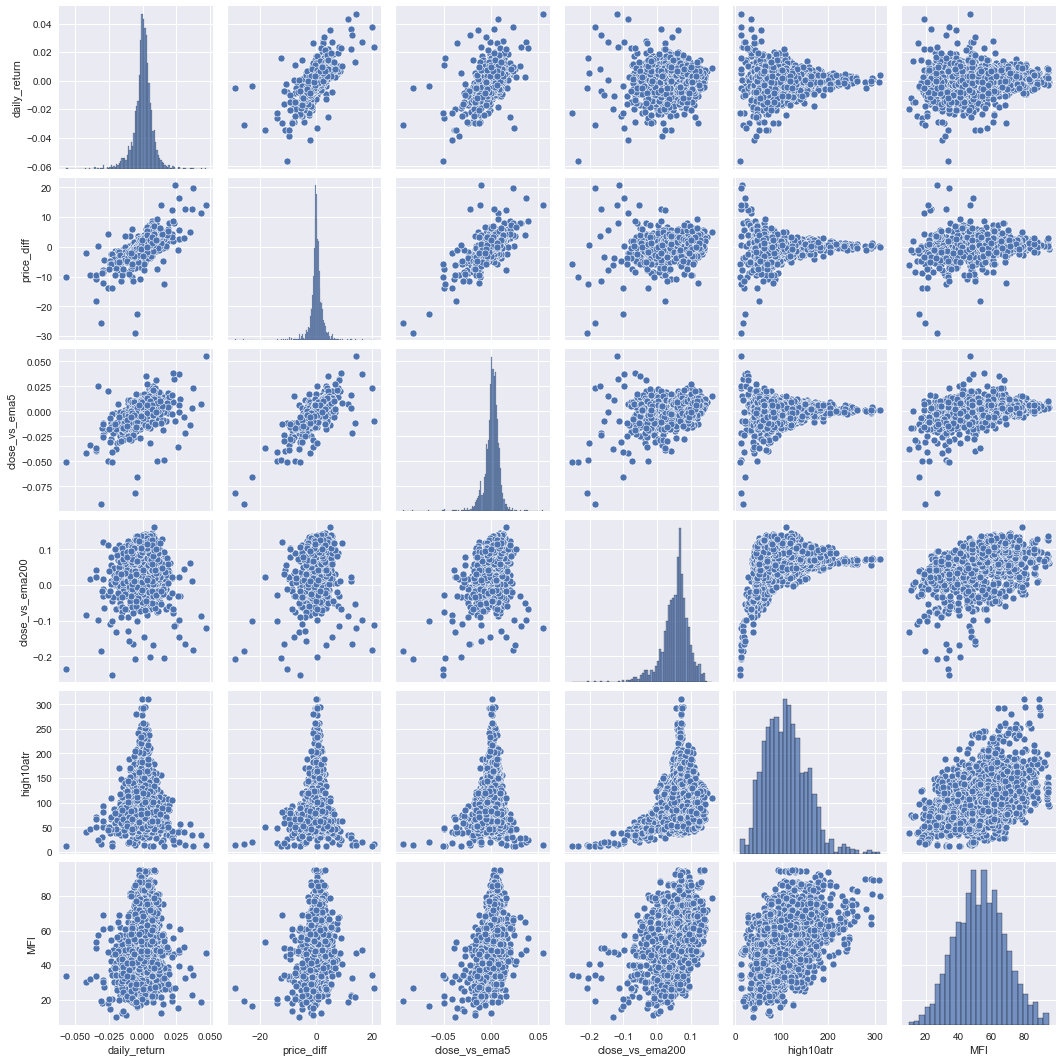

In [12]:
sns.pairplot(features_selected)

There is still some residual covariance, but we're close.


So far, I have only used a simple correlation statistic on a full range of data thus far, but we shouldn't stop here.

### Correlation over time

Given that we're working with financial time series which is non-stationary and subject to constant regime change, the relationship that has been in place on average may be very unstable over time.

Below I'm plotting the rolling correlation of the selected features

<AxesSubplot:title={'center':'Correlation of features with target (by month)'}, xlabel='Date'>

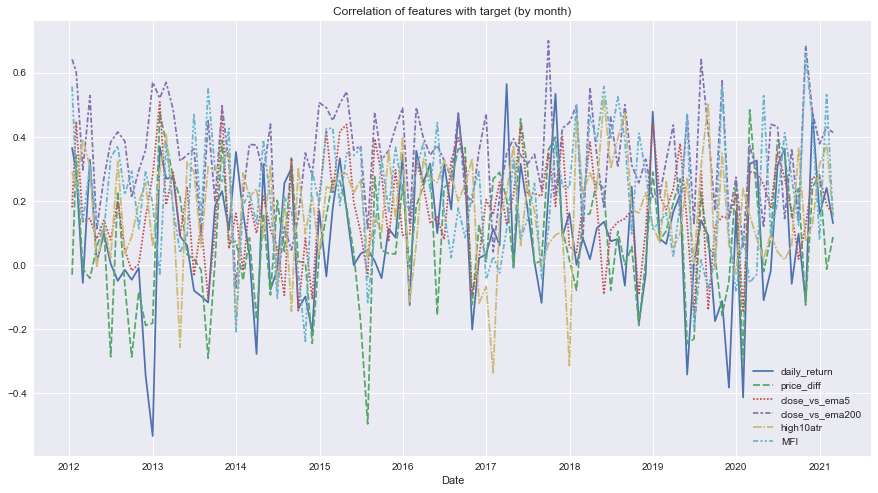

In [13]:
recalc_dates = df_SPY.resample('M').mean().index # Resample by month
recalc_dates = recalc_dates.insert(item=min(df_SPY.index), loc=0) # Add starting date
corrs = pd.DataFrame(index=recalc_dates, columns=features_selected.columns)
for i, date in enumerate(recalc_dates):
    try:
        corr = features_selected.loc[recalc_dates[i]:recalc_dates[i+1]].corrwith(df_SPY.loc[recalc_dates[i]:recalc_dates[i+1]]['target_close_1'])
        corrs.loc[date, :] = corr

    except:
        break

corrs = corrs.dropna()
corrs = corrs.apply(lambda x: x.astype(float))

plt.figure(figsize=(15,8))
plt.title('Correlation of features with target (by month)')
sns.lineplot(data=corrs)


This figure shows us that the correlation of features with the target variable are not consistent. In fact, most features are oscillating between positive and negative values. This may result in a poor fit when modelling with Linear Regression.

# Modelling

### Splitting data and re-scaling

#### Simple splitting (80/20)

Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [351]:
split_point = int(0.80*len(df))

train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]

X_train = train_dataset.iloc[:,:-1]
y_train = train_dataset['target_close_1']

X_test = features_selected.iloc[split_point:,:] 
y_test = df_SPY['target_close_1'].iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)
y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))


# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)
y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))


### Linear Regression

R2 in-sample: 0.006841554763630797
R2 out-of-sample: -0.002604519762377633
Regression Coefficients: [[ 0.06127203 -0.05662569  0.02237183  0.06219529 -0.00978876  0.01127296]]


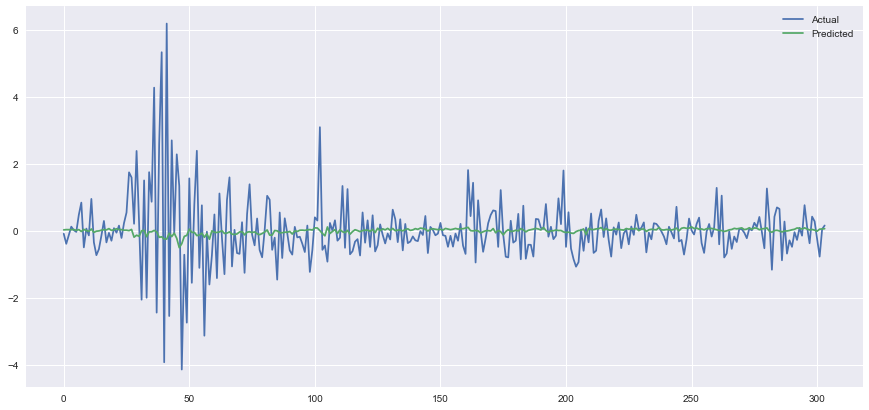

In [282]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

print('R2 in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('R2 out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
print('Regression Coefficients: {}'.format(model.coef_))

lr_pred = model.predict(X_test)

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(lr_pred, label='Predicted')
plt.legend()
plt.show()

### XGBoost Regressor

R2 out-of-sample -0.30400563047528073


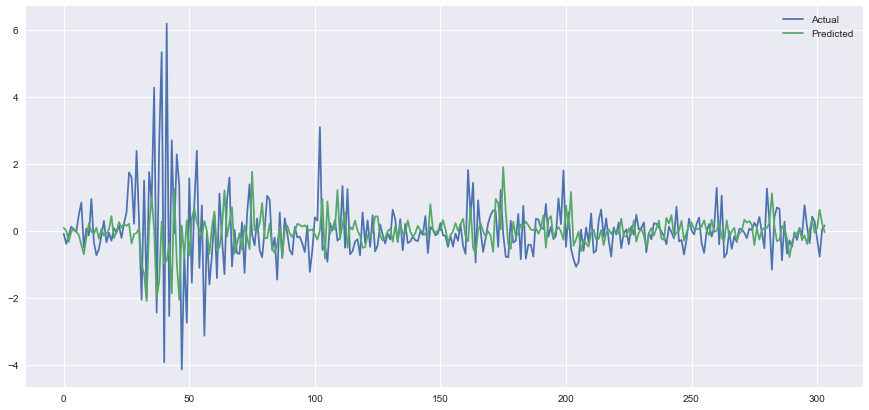

In [250]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print('R2 out-of-sample {}'.format(r2_score(y_test, xgb_pred)))

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(xgb_pred, label='Predicted')
plt.legend()
plt.show()

### Random Forest

<ipython-input-251-9414afa13549>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


R2 out-of-sample -0.08977221531377522


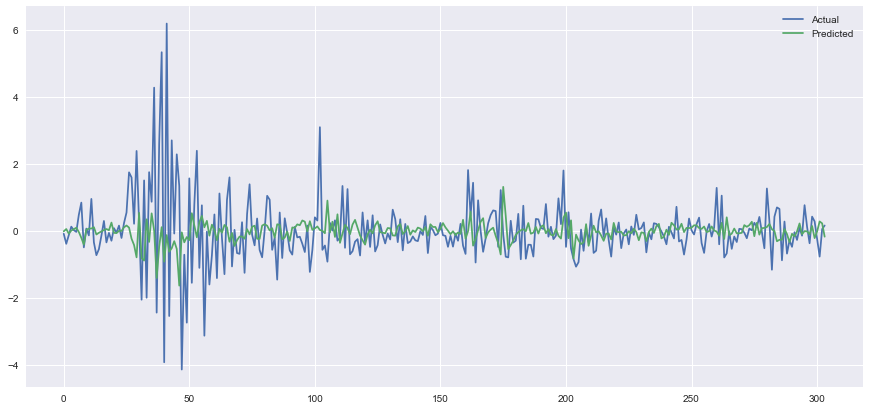

In [251]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

rf_pred = regr.predict(X_test)
print('R2 out-of-sample {}'.format(r2_score(y_test, rf_pred)))

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(rf_pred, label='Predicted')
plt.legend()
plt.show()

As we can see, this results in a terrible fit. We could not predict the target value at all. For out-of-sample dataset, we got negative R2 which means that the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

Is there a better approach?

## Walk-Forward framework


Once again, it is important to highlight that in financial time-series data, common technique such as train-test split (with shuffle) and cross validation have significant flows and therefore should be avoided.


Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


We will be using two approaches:
1. Expanding Window
2. Rolling Window

### Expanding Window

Training the models

In [165]:
recalc_dates = features_selected.resample('M').mean().index[:-1]

models = pd.Series(index=recalc_dates, dtype='object')
for date in recalc_dates:
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    
    print("Training on the first {} records, from {} to {}".
          format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    print("Coefficients: {}".format((model.coef_)))


Training on the first 12 records, from 2012-01-13 00:00:00 to 2012-01-31 00:00:00
Coefficients: [[ 0.7719099  -0.55164427 -0.00863247  0.39468357 -0.5344385   0.71054012]]
Training on the first 32 records, from 2012-01-13 00:00:00 to 2012-02-29 00:00:00
Coefficients: [[ 0.27168917  0.19921058 -0.59803086  0.42309297  0.52016555  0.99011563]]
Training on the first 54 records, from 2012-01-13 00:00:00 to 2012-03-30 00:00:00
Coefficients: [[ 0.13940156 -0.17379755  0.30425779 -0.00828974  0.45748051  0.26792201]]
Training on the first 74 records, from 2012-01-13 00:00:00 to 2012-04-30 00:00:00
Coefficients: [[ 0.31531364 -0.37032517  0.0550955   0.40685412 -0.18441165 -0.02283345]]
Training on the first 96 records, from 2012-01-13 00:00:00 to 2012-05-31 00:00:00
Coefficients: [[ 0.21762379 -0.2734921   0.1259575   0.0563717  -0.06475574 -0.18726705]]
Training on the first 117 records, from 2012-01-13 00:00:00 to 2012-06-29 00:00:00
Coefficients: [[ 0.17158313 -0.1989792   0.08003581  0.29

Training on the first 1270 records, from 2012-01-13 00:00:00 to 2017-01-31 00:00:00
Coefficients: [[ 0.10091142 -0.12467592  0.06928974  0.02190794  0.05899578 -0.01245262]]
Training on the first 1289 records, from 2012-01-13 00:00:00 to 2017-02-28 00:00:00
Coefficients: [[ 0.09894358 -0.12210924  0.06496966  0.02675748  0.04533339 -0.01039939]]
Training on the first 1312 records, from 2012-01-13 00:00:00 to 2017-03-31 00:00:00
Coefficients: [[ 0.09536344 -0.11639653  0.06423315  0.02598124  0.05024467 -0.01037598]]
Training on the first 1331 records, from 2012-01-13 00:00:00 to 2017-04-28 00:00:00
Coefficients: [[ 0.09850798 -0.11546533  0.06123259  0.02672942  0.04907421 -0.00867512]]
Training on the first 1353 records, from 2012-01-13 00:00:00 to 2017-05-31 00:00:00
Coefficients: [[ 0.09856209 -0.11766099  0.06378327  0.02683588  0.049467   -0.00897235]]
Training on the first 1375 records, from 2012-01-13 00:00:00 to 2017-06-30 00:00:00
Coefficients: [[ 0.09600771 -0.1106392   0.060

We can visualise how the model coefficients change over time using the below function

<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

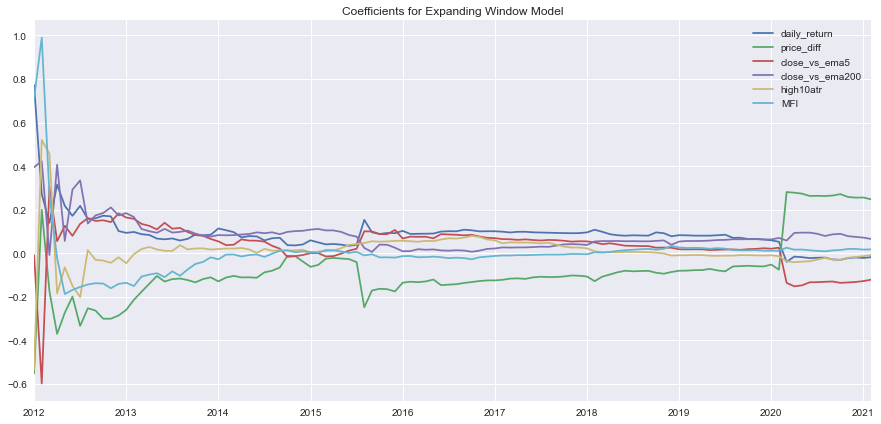

In [166]:
def build_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_[0],index=features_selected.columns.values)
        model_coefs.name = models.index[i]
        coefs = pd.concat([coefs, model_coefs],axis=1)
    return coefs.T

build_coefs(models).plot(title='Coefficients for Expanding Window Model', figsize=(15, 7))

The significance of coefficients vary as we include more data to train.


### Rolling Window

<ipython-input-167-39ab4119a74e>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models = pd.Series(index=recalc_dates)


 Training on the most recent 12 records
            from 2012-01-13 00:00:00 to 2012-01-31 00:00:00
 Training on the most recent 22 records
            from 2012-01-30 00:00:00 to 2012-02-29 00:00:00
 Training on the most recent 22 records
            from 2012-03-01 00:00:00 to 2012-03-30 00:00:00
 Training on the most recent 20 records
            from 2012-04-02 00:00:00 to 2012-04-30 00:00:00
 Training on the most recent 22 records
            from 2012-05-01 00:00:00 to 2012-05-31 00:00:00
 Training on the most recent 22 records
            from 2012-05-31 00:00:00 to 2012-06-29 00:00:00
 Training on the most recent 21 records
            from 2012-07-02 00:00:00 to 2012-07-31 00:00:00
 Training on the most recent 23 records
            from 2012-08-01 00:00:00 to 2012-08-31 00:00:00
 Training on the most recent 20 records
            from 2012-08-31 00:00:00 to 2012-09-28 00:00:00
 Training on the most recent 21 records
            from 2012-10-01 00:00:00 to 2012-10-31 00:00:00


 Training on the most recent 19 records
            from 2018-12-03 00:00:00 to 2018-12-31 00:00:00
 Training on the most recent 21 records
            from 2019-01-02 00:00:00 to 2019-01-31 00:00:00
 Training on the most recent 22 records
            from 2019-01-29 00:00:00 to 2019-02-28 00:00:00
 Training on the most recent 21 records
            from 2019-03-01 00:00:00 to 2019-03-29 00:00:00
 Training on the most recent 21 records
            from 2019-04-01 00:00:00 to 2019-04-30 00:00:00
 Training on the most recent 22 records
            from 2019-05-01 00:00:00 to 2019-05-31 00:00:00
 Training on the most recent 21 records
            from 2019-05-31 00:00:00 to 2019-06-28 00:00:00
 Training on the most recent 22 records
            from 2019-07-01 00:00:00 to 2019-07-31 00:00:00
 Training on the most recent 22 records
            from 2019-08-01 00:00:00 to 2019-08-30 00:00:00
 Training on the most recent 20 records
            from 2019-09-03 00:00:00 to 2019-09-30 00:00:00


<AxesSubplot:title={'center':'Coefficients for Rolling Window Model'}>

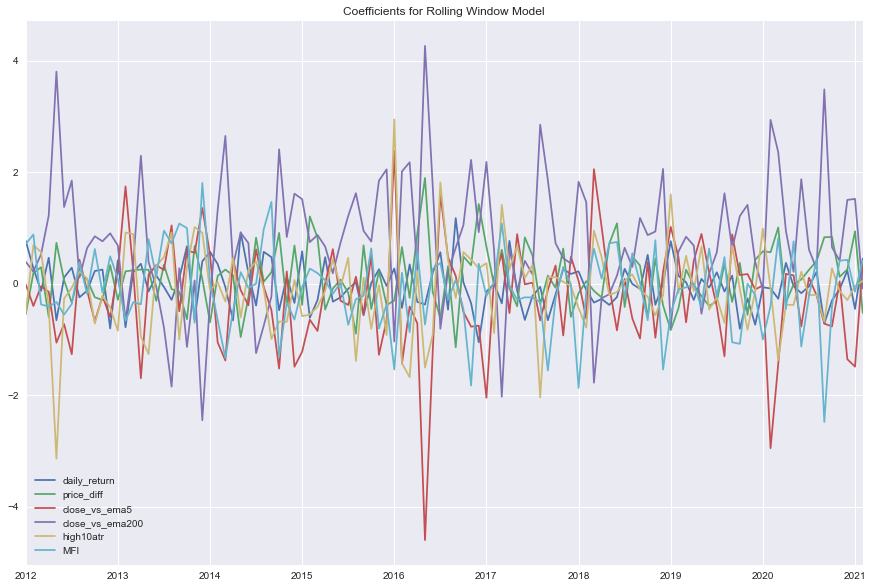

In [167]:
recalc_dates = features_selected.resample('M').mean().index.values[:-1]
models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features_selected.loc[date-pd.Timedelta('30 days'):date]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    print(""" Training on the most recent {} records
            from {} to {}""".format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    
build_coefs(models).plot(title='Coefficients for Rolling Window Model', figsize=(15, 10))


As we can see, the coefficients vary over time.

## Using Models

Next step is to use the models trained above. 
We will create two array, `begin_dates` and `end_dates` that contain the dates on which each model is used. For example, for the first model, we'll apply this model to features beginning on the date we trained the model (`recalc_date`) until the day the next model is trained.

The `end_dates` drops the 0th element and appends to the latest date in the dataset (`df_SPY.index[-1]`)

### Linear Regression

In [223]:
models_expanding_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = df_SPY.loc[date-pd.Timedelta('30 days'):date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_rolling_window.loc[date] = model
    

begin_dates = models.index[:-1]
end_dates = models.index[1:-1]
end_dates = end_dates.insert(item=df_SPY.index[-1], loc=len(end_dates)) 

predictions_expanding_window = pd.Series(index=features.index, dtype='float')

for i, model in enumerate(models_expanding_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index, dtype='float')
for i, model in enumerate(models_rolling_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
    predictions_rolling_window.loc[X.index] = p

The code above looped through each of the models we had trained at various points in time and, for each, used that model to predict the period of time until the next model became available.

In [224]:
y_true = standard_scaler.fit_transform(df_SPY['target_close_1'].loc[predictions_rolling_window.dropna().index].values.reshape(-1, 1))
y_true = pd.Series(np.concatenate(y_true), index=predictions_rolling_window.dropna().index)

r2_expanding = r2_score(y_true=y_true, y_pred=predictions_expanding_window.dropna())
r2_rolling = r2_score(y_true=y_true, y_pred=predictions_rolling_window.dropna())

print("Expanding Window R2: {}".format(round(r2_expanding,3)))
print("Rolling Window R2: {}".format(round(r2_rolling,3)))

Expanding Window R2: -0.001
Rolling Window R2: -1.272


In [225]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=predictions_expanding_window[common_idx])

print("R2 out of sample (rolling): {}".format(round(r2_rolling,3)))
print("R2 out of sample (expanding): {}".format(round(r2_expanding,3)))

plt.title('True vs Predicted - Rolling Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(predictions_rolling_window[common_idx], label='Predicted')
plt.legend()
plt.show()

plt.title('True vs Predicted - Expanding Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(predictions_expanding_window[common_idx], label='Predicted')
plt.legend()
plt.show()

R2 out of sample (rolling): -1.438
R2 out of sample (expanding): 0.007


### XGBoost

In [227]:
xgb_models_expanding_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = features_selected.loc[:date, :]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = xgb.XGBRegressor()
    model.fit(X_train_scaled, y_train_scaled)
    xgb_models_expanding_window.loc[date] = model
    
xgb_models_rolling_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = features_selected.loc[date - pd.Timedelta('30 days'):date, :]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = xgb.XGBRegressor()
    model.fit(X_train_scaled, y_train_scaled)
    xgb_models_rolling_window.loc[date] = model
    

begin_dates = models.index[:-1]
end_dates = models.index[1:-1]
end_dates = end_dates.insert(item=df_SPY.index[-1], loc=len(end_dates)) 

xgb_predictions_expanding_window = pd.Series(index=features.index, dtype='float')

for i, model in enumerate(xgb_models_expanding_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
    xgb_predictions_expanding_window.loc[X.index] = p
    
xgb_predictions_rolling_window = pd.Series(index=features.index, dtype='float')
for i, model in enumerate(xgb_models_rolling_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
    xgb_predictions_rolling_window.loc[X.index] = p

R2 out of sample (rolling): -0.811
R2 out of sample (expanding): -0.328


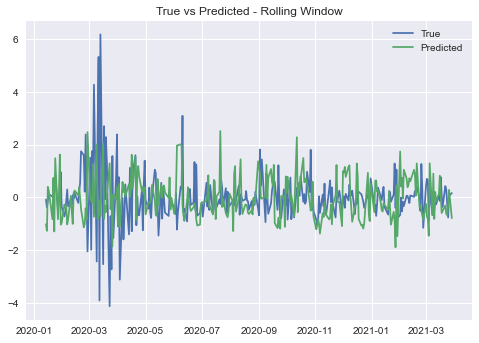

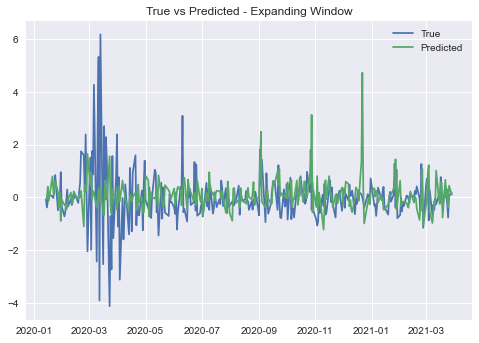

In [228]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

common_idx = y_test.dropna().index.intersection(xgb_predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_expanding_window[common_idx])
print("R2 out of sample (rolling): {}".format(round(r2_rolling,3)))
print("R2 out of sample (expanding): {}".format(round(r2_expanding,3)))


plt.title('True vs Predicted - Rolling Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(xgb_predictions_rolling_window[common_idx], label='Predicted')
plt.legend()
plt.show()

plt.title('True vs Predicted - Expanding Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(xgb_predictions_expanding_window[common_idx], label='Predicted')
plt.legend()
plt.show()

## Evaluating Model

### Tradional regression model evaluation

R-squared don't tell us much by itself. It does not provide insights about the practicality of this signal from a trading point of view.

Instead of using generic ML metric like R-squared, we will create several custom metrics that will provide a more complete picture of strength, reliability, and practicality of these models.


#### Pre-processing of data primitives

Prior to implementation of specific metrics, some data pre-processing is required. This will help us save some time later when calculating final metrics.

The following inputs will be required:

*`y_pred`: the continuous variable prediction made by our model for each timestep

*`y_true`: the continuous variable actual outcome for each timestep

We will then feed this data into a simple function below to derive the following:

*`sign_pred`: sign of prediction

*`sign_true`: sign of true outcome

*`is_correct`: 1 if sign_pred == sign_true, else 0

*`is_incorrect`: opposite

*`is_predicted`: 1 if the model has made a valid prediction, 0 if not. This is important if models only emit predictions when they have a certain level of confidence

*`result`: the profit (loss) resulting from betting one unit in the direction of the sign_pred. This is the continuous variable result of following the model

In [316]:
def construct_df(y_pred, y_true):
    """
    Constructs new dataframe that consists of the following columns:
    sign_pred: 
        sign of prediction
    sign_true: 
        sign of true outcome
    is_correct: 
        1 if sign_pred == sign_true, else 0
    is_incorrect: 
        0 if sign_pred == sign_true, else 1
    is_predicted: 
        1 if the model has made a valid prediction, 0 if not. 
        This is important if models only emit predictions when they have a certain level of confidence
    result: 
        the profit (loss) resulting from betting one unit in the direction of the sign_pred. 
        This is the continuous variable result of following the model

    """
#     indices = df_SPY['target_close_1'].iloc[split_point:].index
    y_pred = pd.Series(y_pred, name='y_pred')
    y_true = pd.Series(y_true, name='y_true')
    
    df = pd.concat([y_pred, y_true], axis=1)
    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # 1 when prediction was made and it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # 1 when prediction was made and it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df

metrics = construct_df(predictions['LR_rolling'], y_test)
metrics

,y_pred,y_true,sign_pred,sign_true,is_correct,is_incorrect,is_predicted,result
Date,,,,,,,,
2020-01-14,0.325757,-0.088442,1.0,-1.0,0,1,1,-0.088442
2020-01-15,0.147400,-0.388828,1.0,-1.0,0,1,1,-0.388828
2020-01-16,0.554375,-0.130944,1.0,-1.0,0,1,1,-0.130944
2020-01-17,0.589992,0.122837,1.0,1.0,1,0,1,0.122837
2020-01-21,0.159364,0.018488,1.0,1.0,1,0,1,0.018488
...,...,...,...,...,...,...,...,...
2021-03-23,-0.680378,0.280538,-1.0,1.0,0,1,1,-0.280538
2021-03-24,-0.491286,-0.255763,-1.0,-1.0,1,0,1,0.255763
2021-03-25,-1.096435,-0.770105,-1.0,-1.0,1,0,1,0.770105


#### Defining new metrics


Having these intermediate pre-processed will allow us to calculate the metric more easily. These metrics include:
* *Accuracy*: Percent of predictions that were correct vs. incorrect
* *Noise*: Estimates how dramatically the model's predictions vary from one day to the next
* *Edge*: Expected value of the prediction over a sufficiently large set of draws
* *y_true_chg and y_pred_chg*: The average magnitude of change (per period) in y_true and y_pred.
* *prediction_calibration*: ratio of the magnitude of our predictions vs. magnitude of truth. Provides some indication of whether our model is properly tuned to the size of movement in addition to the direction of it.
* *capture_ratio*: Ratio of the "edge" we gain by following  predictions vs. the actual daily change. 100 would indicate that we were perfectly capturing the true movement of the target variable.


In [254]:
def calc_metrics(df):
    metrics = pd.Series()
    metrics.loc['accuracy'] = df['is_correct'].sum() / (df['is_predicted'].sum())*100
    metrics.loc['edge'] = df['result'].mean()
    metrics.loc['noise'] = df['y_pred'].diff().abs().mean()
    
    metrics.loc['y_true_chg'] = df['y_true'].abs().mean()
    metrics.loc['y_pred_chg'] = df['y_pred'].abs().mean()
    metrics.loc['prediction_calibration'] = metrics.loc['y_pred_chg']/metrics.loc['y_true_chg']
    metrics.loc['capture_ratio'] = metrics['edge']/metrics.loc['y_true_chg']*100

    return metrics    

calc_metrics(metrics)

<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()


accuracy                  46.381579
edge                      -0.040091
noise                      0.429724
y_true_chg                 0.620163
y_pred_chg                 0.299910
prediction_calibration     0.483599
capture_ratio             -6.464544
dtype: float64

Comparing all models

In [352]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

# Combine all predictions
# Create series
lr_pred_series = pd.Series(np.concatenate(lr_pred), name='LR_simple_split', index=y_test.index)
xgb_pred_series = pd.Series(xgb_pred, name='XGB_simple_split', index=y_test.index)
xgb_rw_series = pd.Series(xgb_predictions_rolling_window[common_idx], name='XGB_rolling')
xgb_ew_series = pd.Series(xgb_predictions_expanding_window[common_idx], name='XGB_expanding')
lr_rw_series = pd.Series(predictions_rolling_window[common_idx], name='LR_rolling')
lr_ew_series = pd.Series(predictions_expanding_window[common_idx], name='LR_expanding')

# Concatenate predictions
predictions = pd.concat([lr_pred_series, xgb_pred_series, 
                         lr_rw_series, lr_ew_series,
                         xgb_rw_series, xgb_ew_series
                        ], axis=1)

common_idx = y_test.dropna().index.intersection(xgb_predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_expanding_window[common_idx])

In [348]:
models_metrics = pd.DataFrame(index=predictions.columns, 
                              columns=['accuracy', 'edge', 'noise', 'y_true_chg', 
                                        'y_pred_chg', 'prediction_calibration', 'capture_ratio'])
for p in predictions:
    models_metrics.loc[p, :] = calc_metrics(construct_df(predictions[p], y_test))


<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-254-64dd39f5e690>:2: DeprecationWarning: The default dtype for empty Series will 

In [349]:
models_metrics

,accuracy,edge,noise,y_true_chg,y_pred_chg,prediction_calibration,capture_ratio
LR_simple_split,50.9868,0.0562467,0.0442652,0.620163,0.0531997,0.0857833,9.06966
XGB_simple_split,46.3816,-0.0400907,0.429724,0.620163,0.29991,0.483599,-6.46454
LR_rolling,55.2632,0.0945593,0.688561,0.620163,0.960517,1.54881,15.2475
LR_expanding,57.5658,0.0894594,0.211926,0.620163,0.136584,0.220238,14.4251
XGB_rolling,54.9342,-0.0746588,0.72305,0.620163,0.644567,1.03935,-12.0386
XGB_expanding,52.9605,0.106977,0.511313,0.620163,0.371867,0.599628,17.2499


# Conclusion

As we saw, predicting the stock market is a very challenging task. 

# References

https://www.investopedia.com/terms/r/rsi.asp

https://www.investopedia.com/terms/m/macd.asp

https://altfins.com/knowledge-base/macd-line-and-macd-signal-line/

https://www.investopedia.com/terms/s/stochasticoscillator.asp

https://www.investopedia.com/terms/a/accumulationdistribution.asp

https://www.investopedia.com/terms/a/atr.asp

https://www.investopedia.com/articles/active-trading/072115/understand-vortex-indicator-trading-strategies.asp

https://www.investopedia.com/terms/e/easeofmovement.asp

https://www.investopedia.com/terms/c/commoditychannelindex.asp

https://www.investopedia.com/terms/o/onbalancevolume.asp

https://www.investopedia.com/terms/m/mfi.asp

https://www.investopedia.com/terms/l/lookaheadbias.asp

